# Import and Read

In [56]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [147]:
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import xgboost as xgb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import randint
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [148]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

In [149]:
df.loc[8314:65671, 'Ebeam'] = 5.754

In [150]:
df['phi'] = df.phi.apply(lambda x: math.radians(x))

# Preprocessing (remove soft dups)

In [151]:
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

In [152]:
feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
label_data = df['dsigma_dOmega']

# Splitting Data into Train and Test

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
feature_data = scaler_feature.fit_transform(feature_data)
label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))

train_feature_data, test_feature_data, train_label_data, test_label_data = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)


# Creating Data Loaders
train_dataset = PhysicsDataSet(train_feature_data, train_label_data)
test_dataset = PhysicsDataSet(test_feature_data, test_label_data)

train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False)

# FCNN

In [153]:
# Creating a Data Set
class PhysicsDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

In [155]:
input_dim = 5
hidden_dim_1 = 60
hidden_dim_2 = 60
hidden_dim_3 = 60
hidden_dim_4 = 60
hidden_dim_5 = 40
output_dim = 1

num_epochs = 5000
early_stop_cond = 0.001
epoch_early_stop = 10
lr=0.0001

In [156]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim_1),
    nn.ReLU(),
    nn.Linear(hidden_dim_1, hidden_dim_2),
    nn.ReLU(),
    nn.Linear(hidden_dim_2, hidden_dim_3),
    nn.ReLU(),
    nn.Linear(hidden_dim_3, hidden_dim_4),
    nn.ReLU(),
    nn.Linear(hidden_dim_4, hidden_dim_5),
    nn.ReLU(),
    nn.Linear(hidden_dim_5, output_dim)
)

# Training the Model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
    for feature, label in train_loader:
        optimizer.zero_grad()
        outputs = model(feature.to(torch.float32))
        loss = criterion(outputs.to(torch.float32), label.to(torch.float32))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    if epoch > epoch_early_stop and abs(epoch_loss - last_loss) < early_stop_cond:
        break
    last_loss = epoch_loss

Epoch: 10/5000, Loss: 692.3198
Epoch: 20/5000, Loss: 509.9955
Epoch: 30/5000, Loss: 443.9345
Epoch: 40/5000, Loss: 403.7749
Epoch: 50/5000, Loss: 390.0723
Epoch: 60/5000, Loss: 364.8489
Epoch: 70/5000, Loss: 359.5180
Epoch: 80/5000, Loss: 346.8385
Epoch: 90/5000, Loss: 340.0151
Epoch: 100/5000, Loss: 331.6656
Epoch: 110/5000, Loss: 325.5208
Epoch: 120/5000, Loss: 318.8625
Epoch: 130/5000, Loss: 310.6479
Epoch: 140/5000, Loss: 311.3699
Epoch: 150/5000, Loss: 305.6262
Epoch: 160/5000, Loss: 297.3291
Epoch: 170/5000, Loss: 298.8273
Epoch: 180/5000, Loss: 293.4405
Epoch: 190/5000, Loss: 292.7839
Epoch: 200/5000, Loss: 286.7785
Epoch: 210/5000, Loss: 279.7251
Epoch: 220/5000, Loss: 278.3131
Epoch: 230/5000, Loss: 274.7782
Epoch: 240/5000, Loss: 272.3416
Epoch: 250/5000, Loss: 266.3707
Epoch: 260/5000, Loss: 262.5920
Epoch: 270/5000, Loss: 261.1180
Epoch: 280/5000, Loss: 259.7653
Epoch: 290/5000, Loss: 252.5197
Epoch: 300/5000, Loss: 249.3171
Epoch: 310/5000, Loss: 245.3531
Epoch: 320/5000, 

Epoch: 2570/5000, Loss: 59.9912
Epoch: 2580/5000, Loss: 61.9495
Epoch: 2590/5000, Loss: 60.1537
Epoch: 2600/5000, Loss: 60.0802
Epoch: 2610/5000, Loss: 65.3497
Epoch: 2620/5000, Loss: 61.5308
Epoch: 2630/5000, Loss: 59.0000
Epoch: 2640/5000, Loss: 58.2709
Epoch: 2650/5000, Loss: 57.1070
Epoch: 2660/5000, Loss: 67.7931
Epoch: 2670/5000, Loss: 64.0012
Epoch: 2680/5000, Loss: 58.1611
Epoch: 2690/5000, Loss: 66.6430
Epoch: 2700/5000, Loss: 57.2690
Epoch: 2710/5000, Loss: 59.1735
Epoch: 2720/5000, Loss: 58.3633
Epoch: 2730/5000, Loss: 56.9570
Epoch: 2740/5000, Loss: 59.4567
Epoch: 2750/5000, Loss: 61.5399
Epoch: 2760/5000, Loss: 60.2985
Epoch: 2770/5000, Loss: 56.1961
Epoch: 2780/5000, Loss: 59.1594
Epoch: 2790/5000, Loss: 59.7380
Epoch: 2800/5000, Loss: 56.5089
Epoch: 2810/5000, Loss: 56.7410
Epoch: 2820/5000, Loss: 56.7443
Epoch: 2830/5000, Loss: 56.8849
Epoch: 2840/5000, Loss: 66.7949
Epoch: 2850/5000, Loss: 59.6085
Epoch: 2860/5000, Loss: 56.5809
Epoch: 2870/5000, Loss: 58.0829
Epoch: 2

KeyboardInterrupt: 

In [157]:
# Testing the Model
test_loss = 0.0
with torch.no_grad():
    for feature, label in test_loader:
        outputs = model(feature.to(torch.float32))
        loss = criterion(outputs.to(torch.float32), label.to(torch.float32))
        test_loss += loss.item()

print('Test Loss: {:.4f}'.format(test_loss))

Test Loss: 94.9867


In [163]:
torch.save(model, './models/5_60_layers')

# Same but 20 examples 

In [169]:
def rundom_example_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        dsigma_dOmega_predicted = scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df_example_set_for_prediction)).to(torch.float32)))
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label='real_data')
    plt.legend()
    plt.show()

a = 0.05294491387874451 , b = -0.025471472627703468, c = 0.01007803683080963


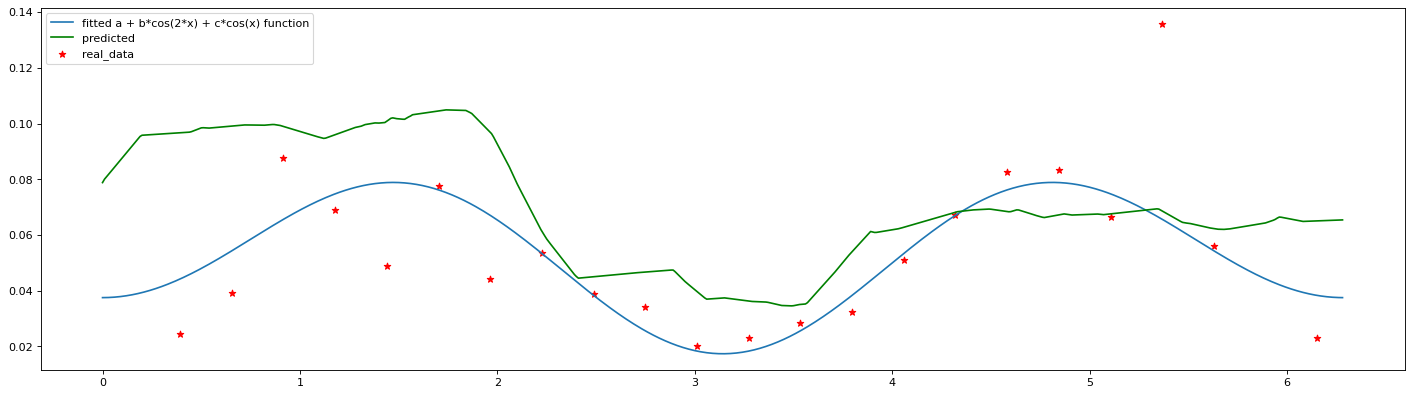

a = 0.321458463101882 , b = 0.05666956794617312, c = -0.04057255065586493


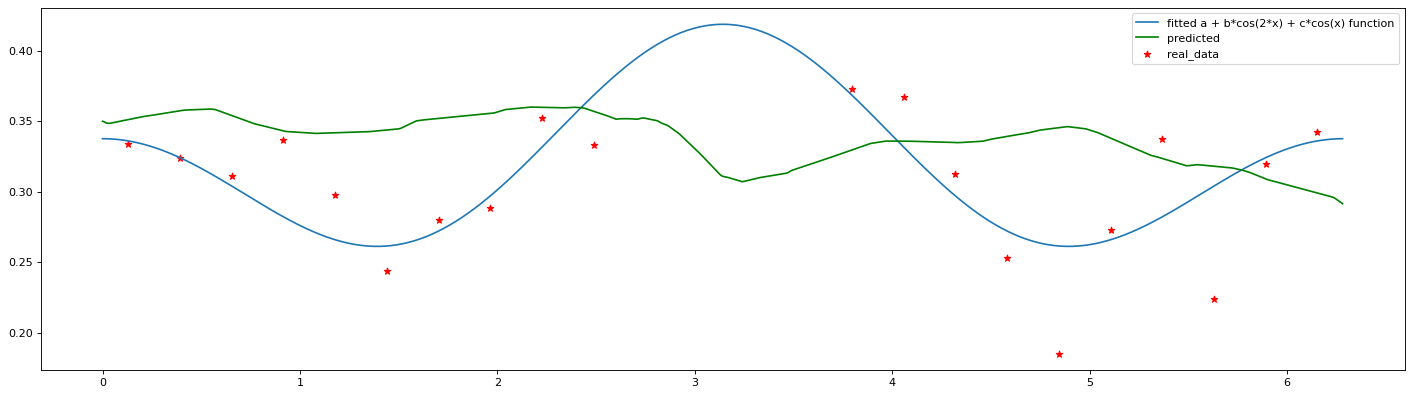

a = 0.3749190565499401 , b = -0.06826647108911915, c = 0.10298973873469067


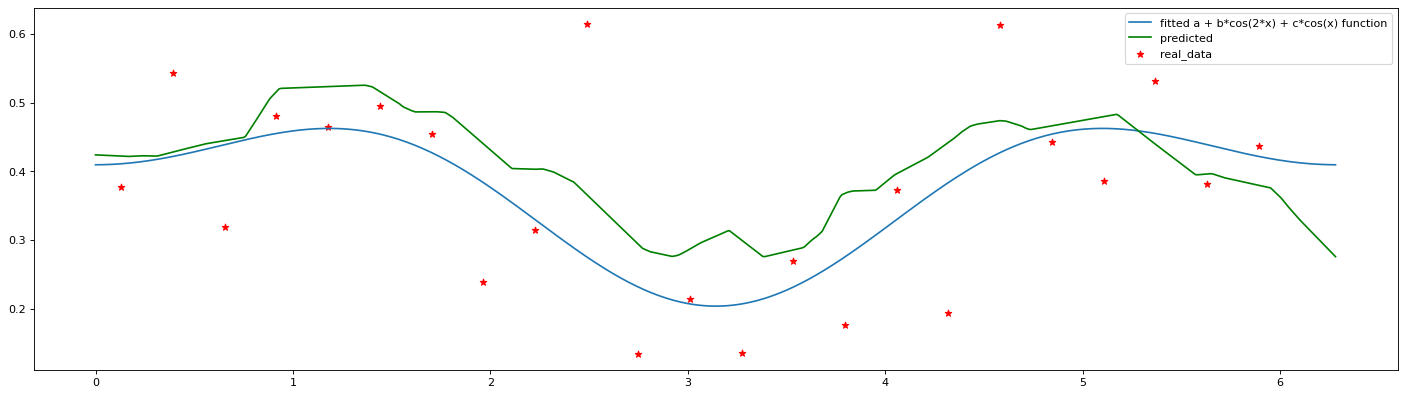

a = 0.4371935711143973 , b = -0.051037470531059226, c = 0.01931965251634926


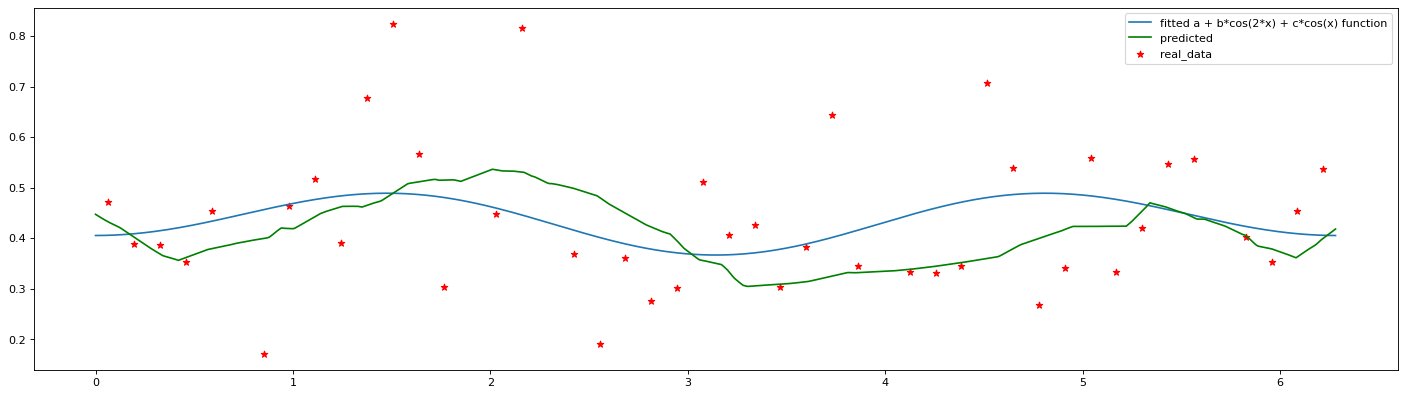

a = 0.3328329166364419 , b = -0.07941457802595409, c = -0.02905387416528789


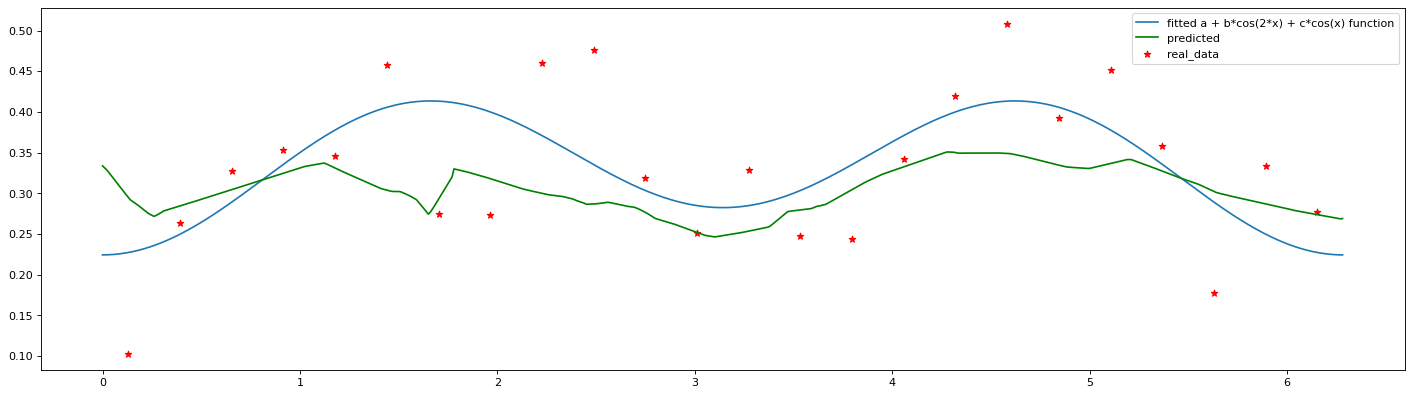

a = 0.48927846001033864 , b = -0.05851277958157131, c = 0.01567276767120049


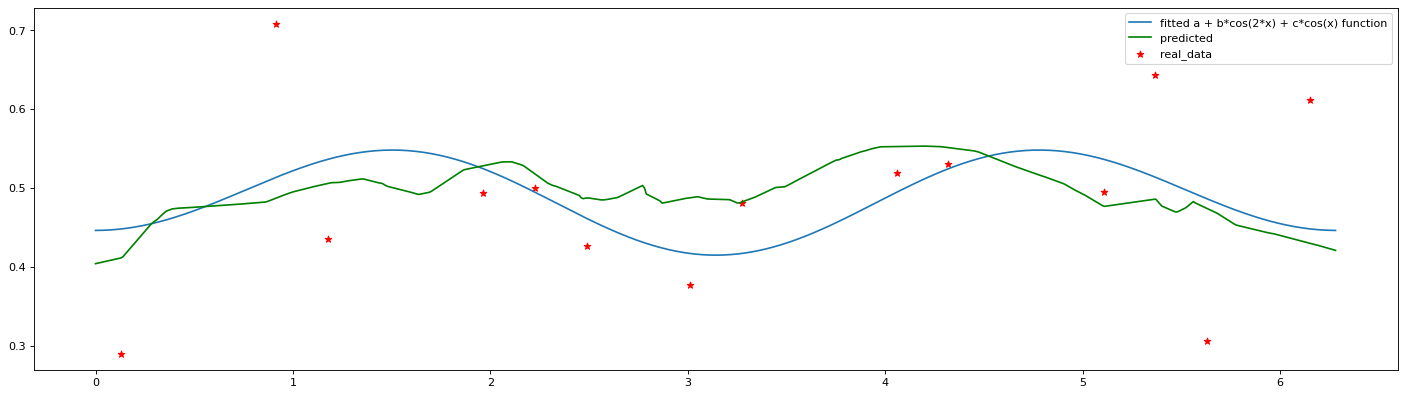

a = 0.37287076943782177 , b = -0.08409839465657508, c = -0.060449972870279915


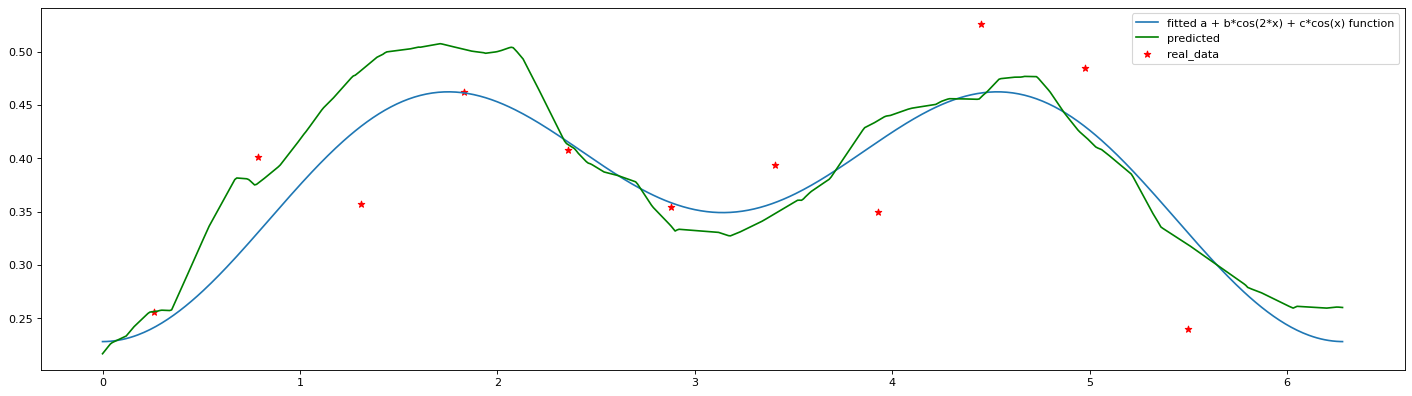

a = 0.3839166666666667 , b = -0.09677833839873919, c = -0.0418315173565701


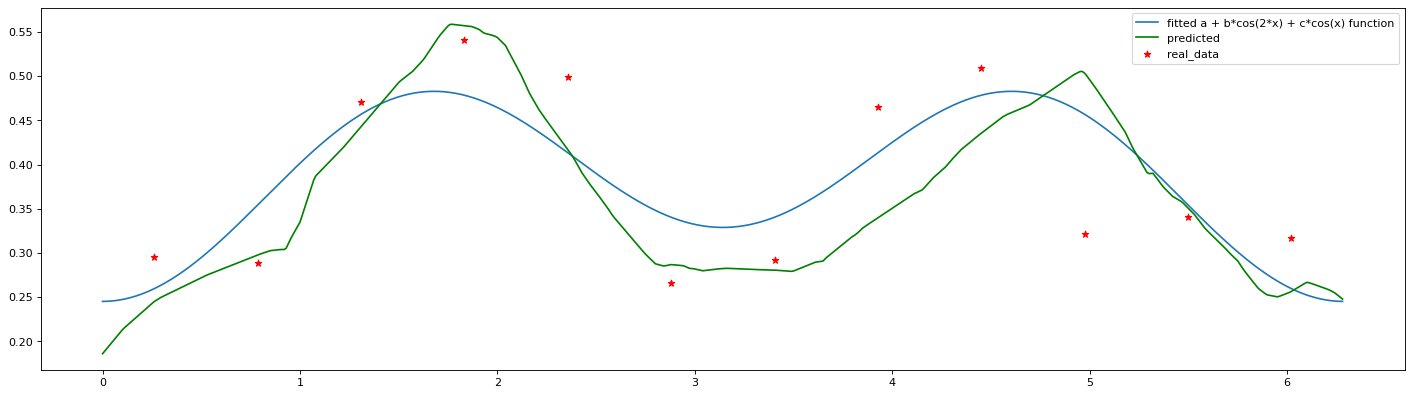

a = 0.32726536208011875 , b = -0.1505388092880933, c = -0.10670764650469806


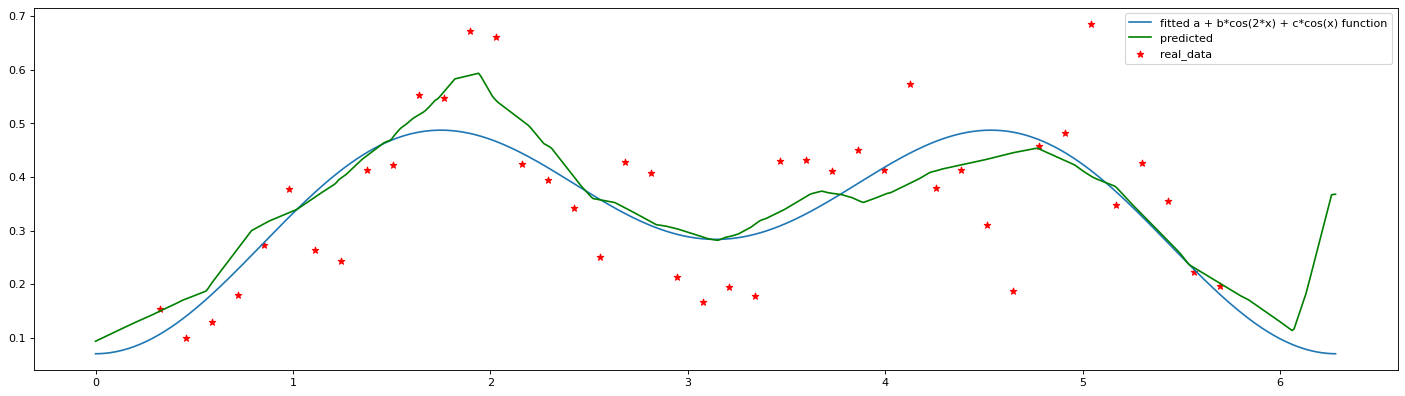

a = 0.9164026597743887 , b = -0.11390135275936718, c = -0.03277892567941805


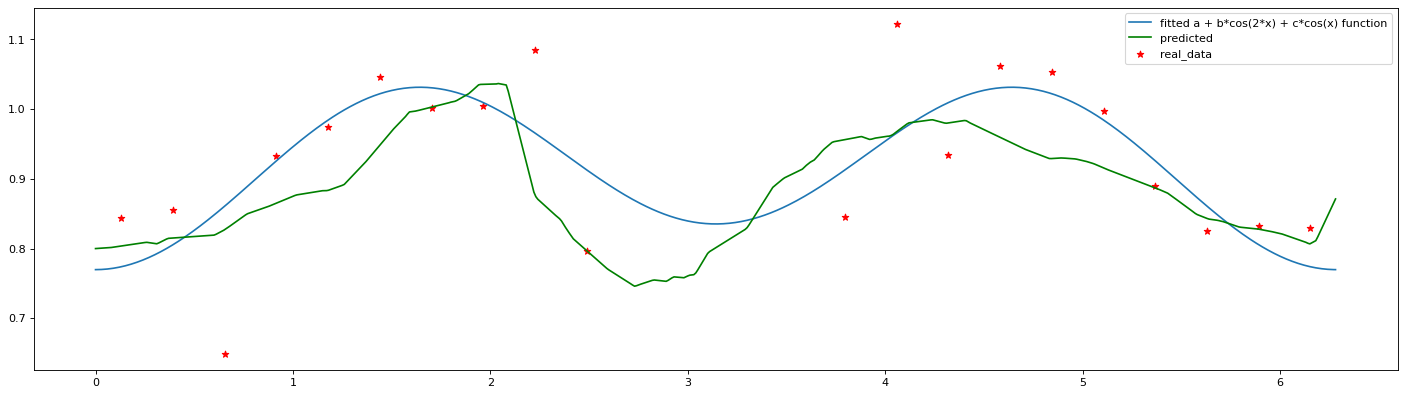

a = 2.071727500741209 , b = -0.09314859917208884, c = 0.003738309626988845


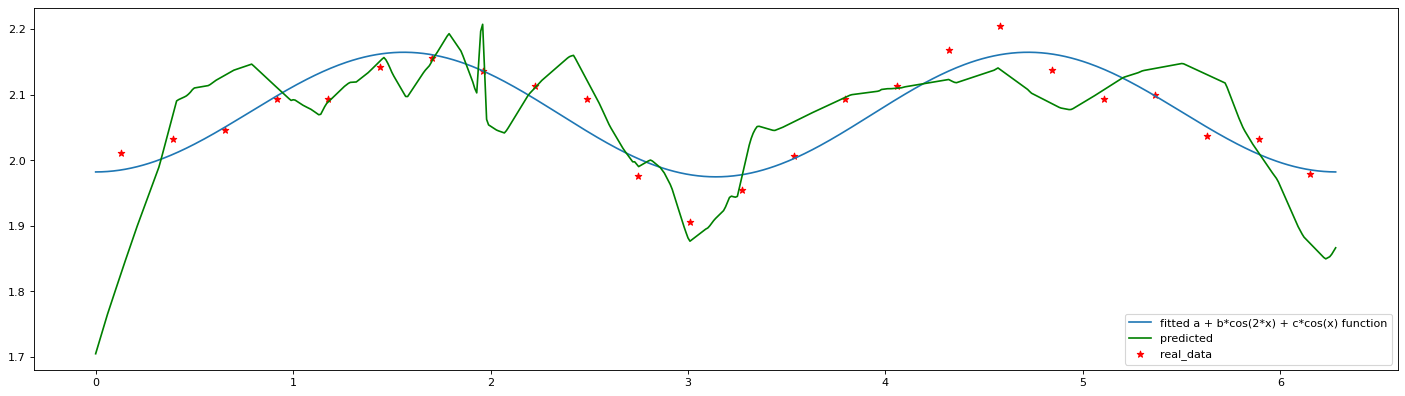

a = 7.798281169327201 , b = -0.846070828258482, c = 2.065149434540566


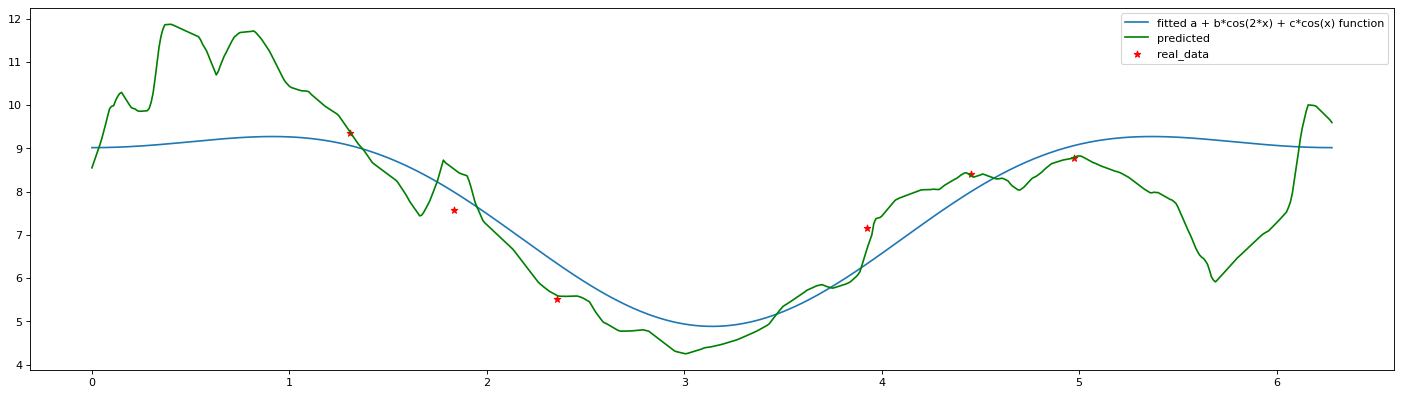

a = 0.3384569580044048 , b = -0.029653771860382924, c = -0.022673082716962327


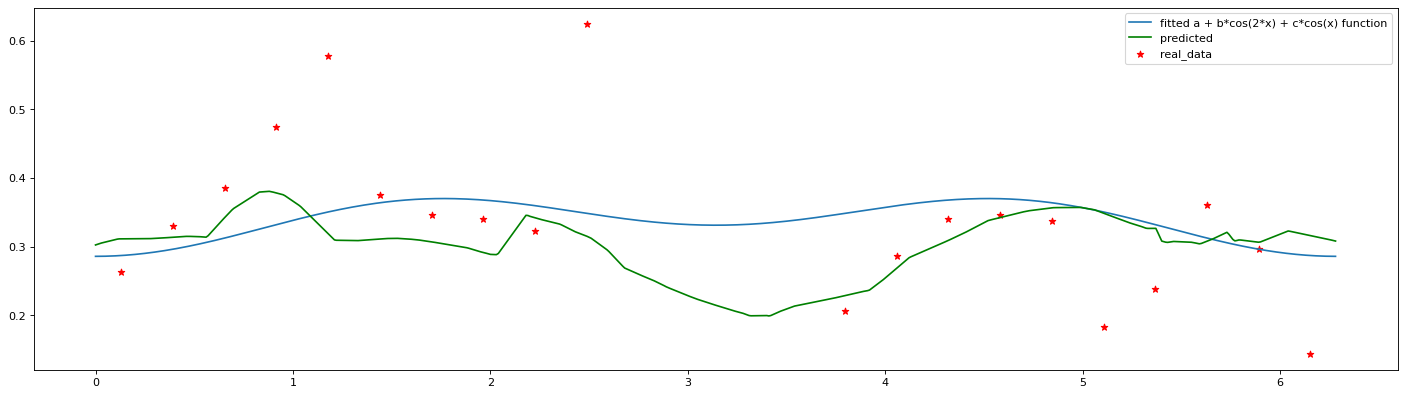

a = 0.9320475617453545 , b = -0.6117236429208446, c = 0.0190818956463632


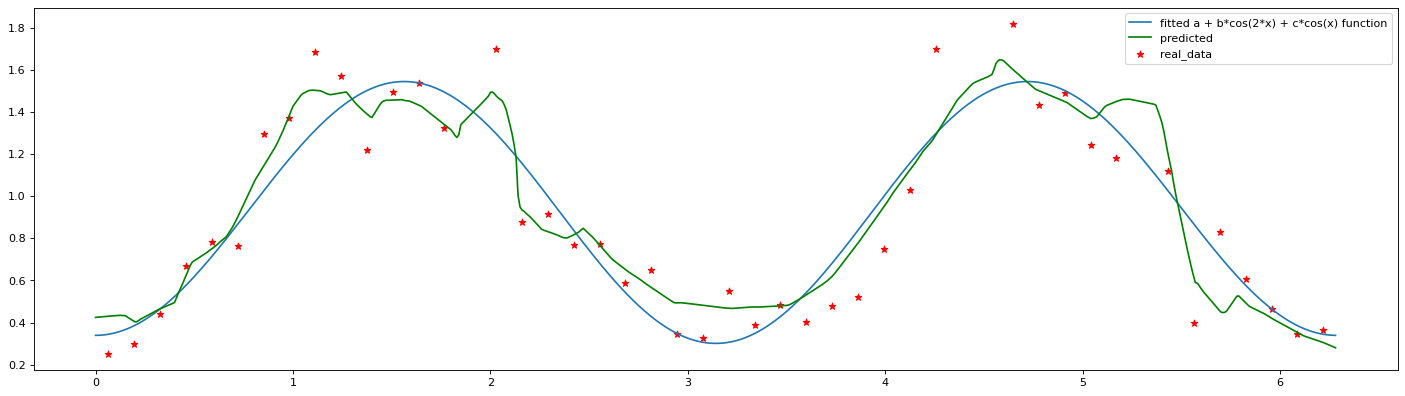

a = 1.307782894153905 , b = -0.3173961514159212, c = -0.03725642640209988


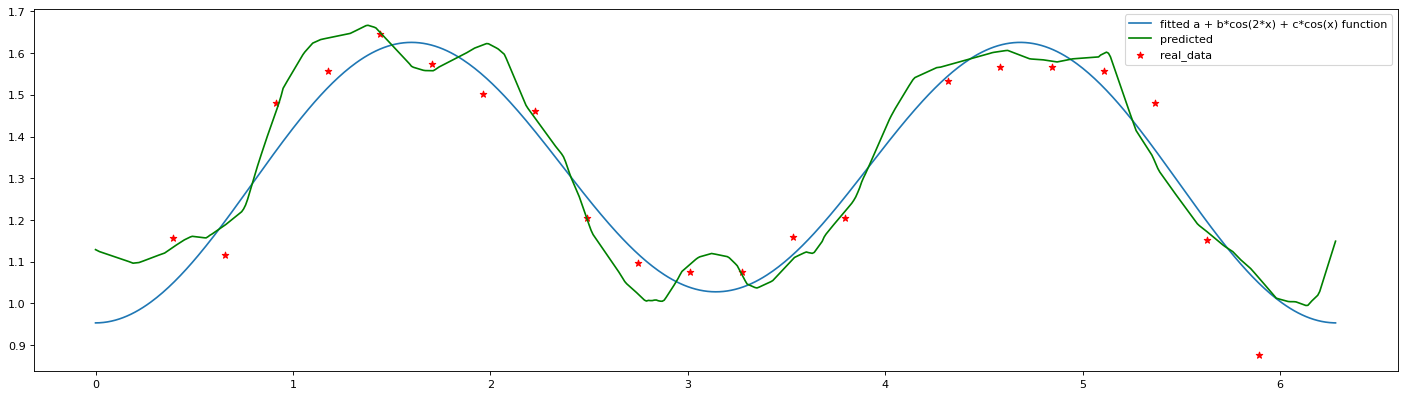

a = 0.43461685782105464 , b = -0.11313278861602089, c = 0.08777185673810022


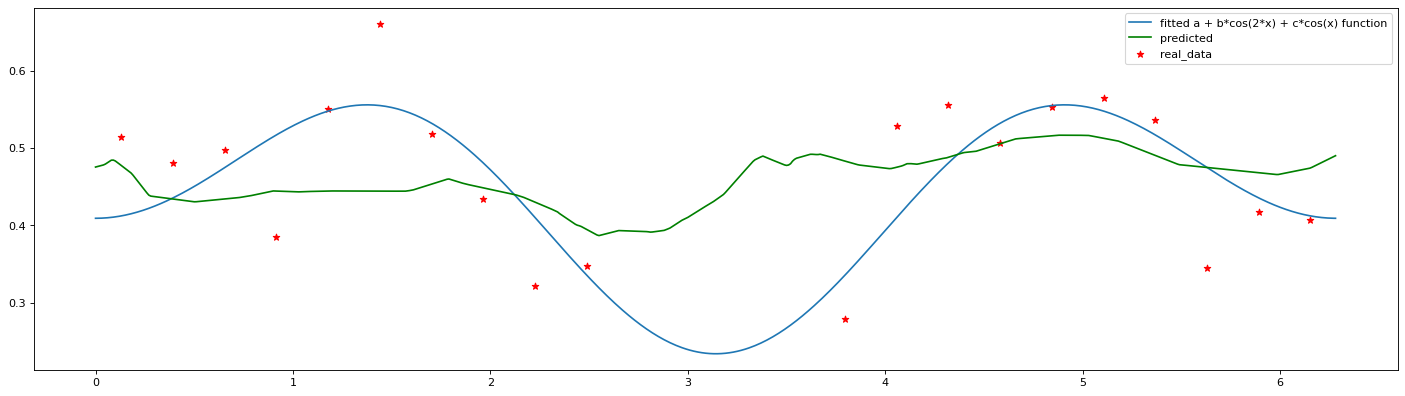

a = 0.16668970229380398 , b = -0.016605665263150073, c = -0.04374098891918197


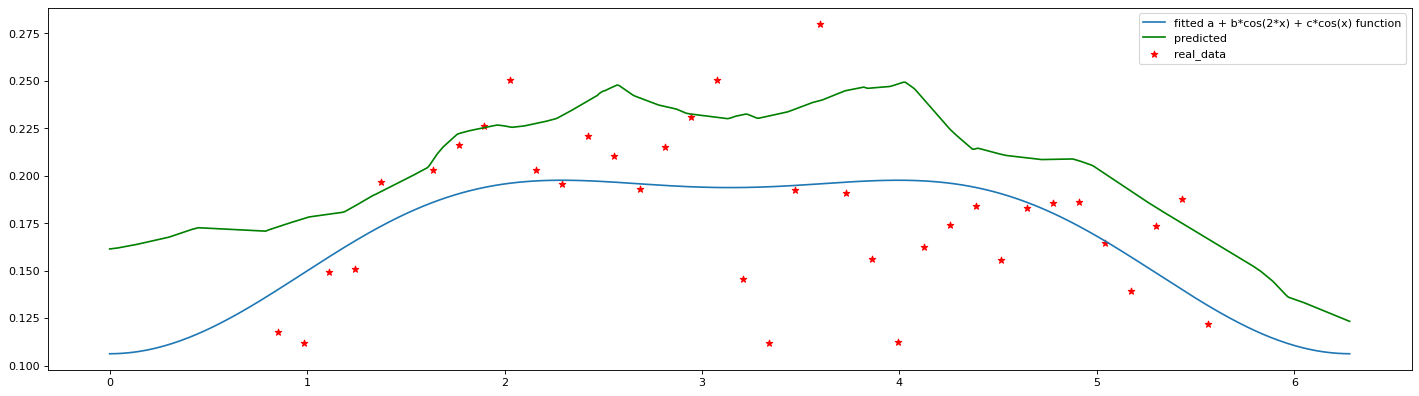

a = 5.141455429663728 , b = -2.0385566634120678, c = -1.5076530251885487


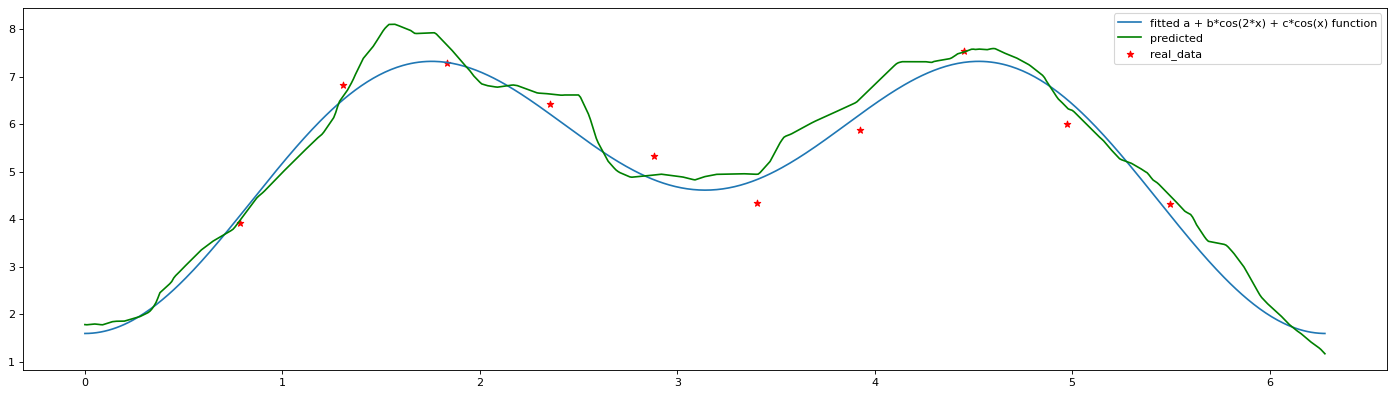

a = 0.38646007655890924 , b = -0.13395785608980948, c = 0.2355800197787422


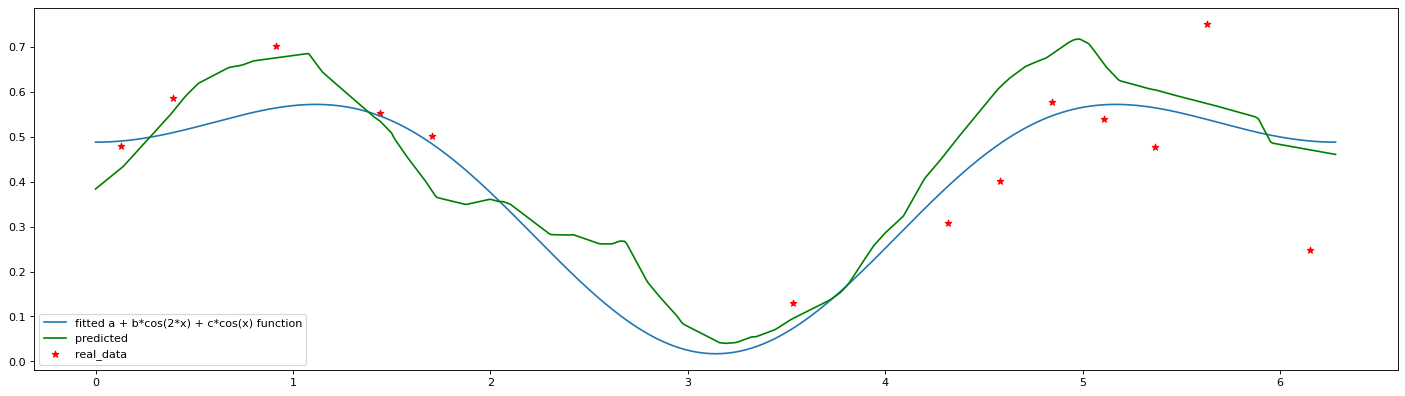

a = 0.06177916666666666 , b = -0.007697932784728976, c = 0.0028494175872906535


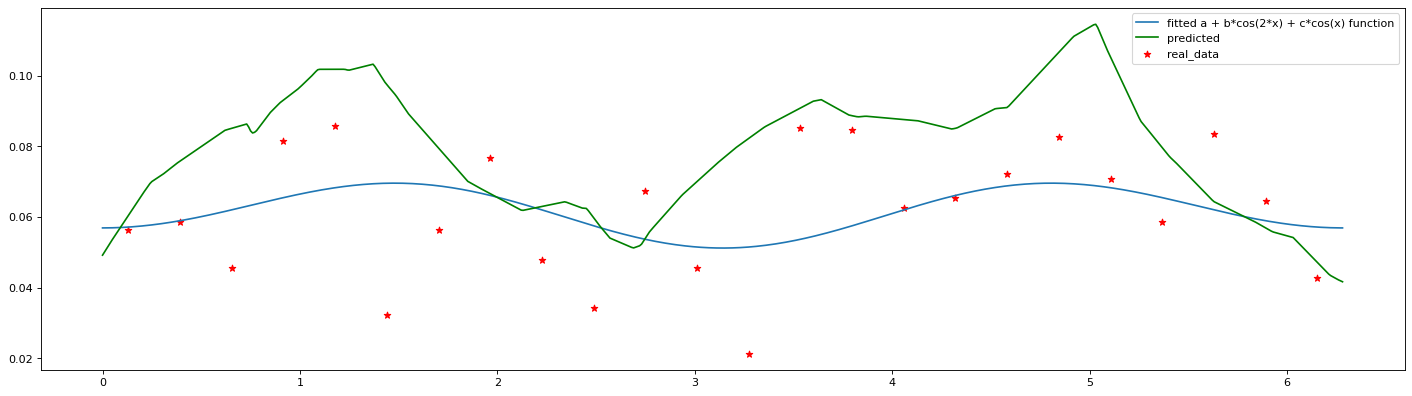

a = 0.16537499999999994 , b = 0.012918212338049122, c = 0.014956099861492716


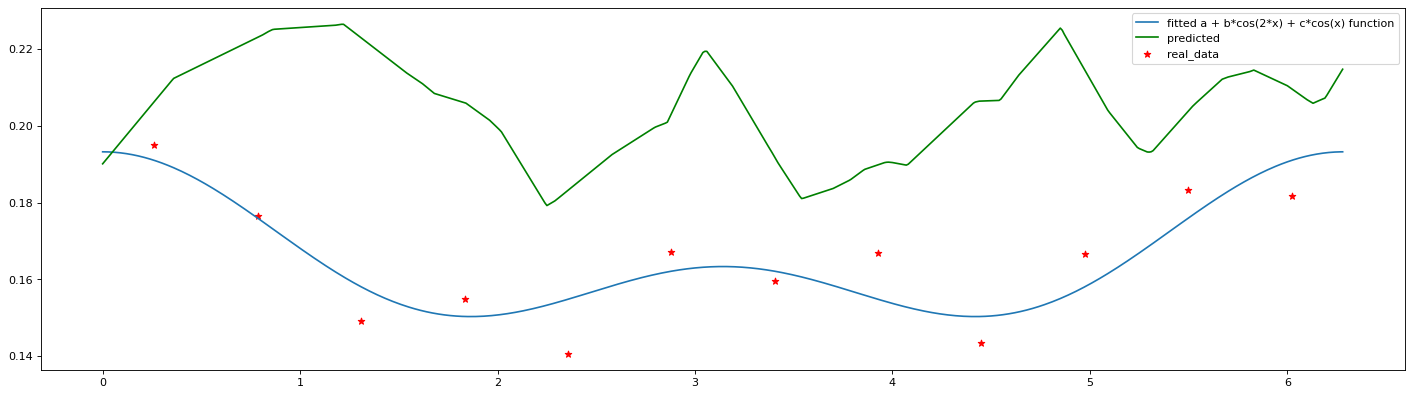

a = 0.31947499998415846 , b = -0.1062226079163352, c = -0.008373634783818841


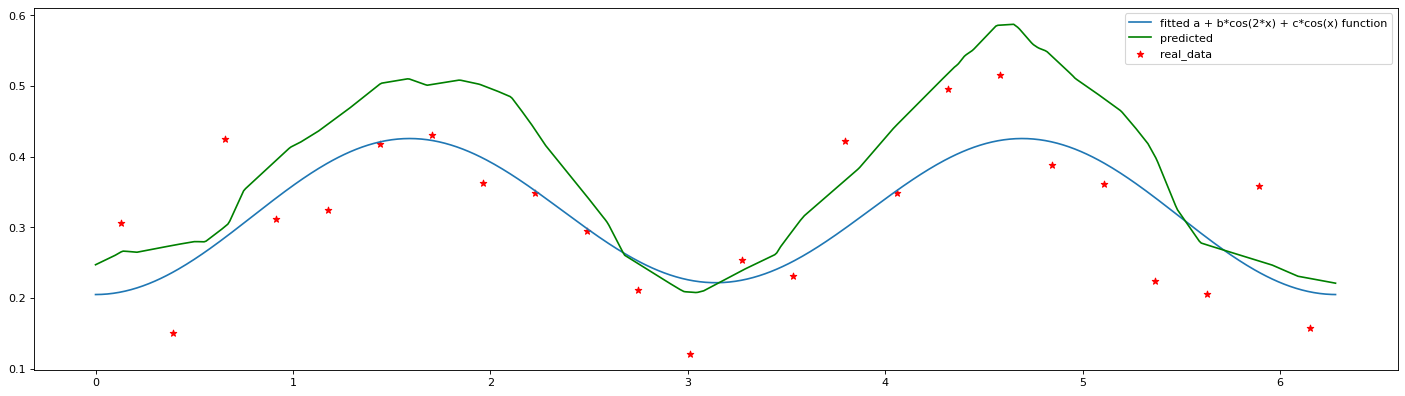

a = 0.14802599169897615 , b = -0.01252264729091473, c = 0.01766477614105541


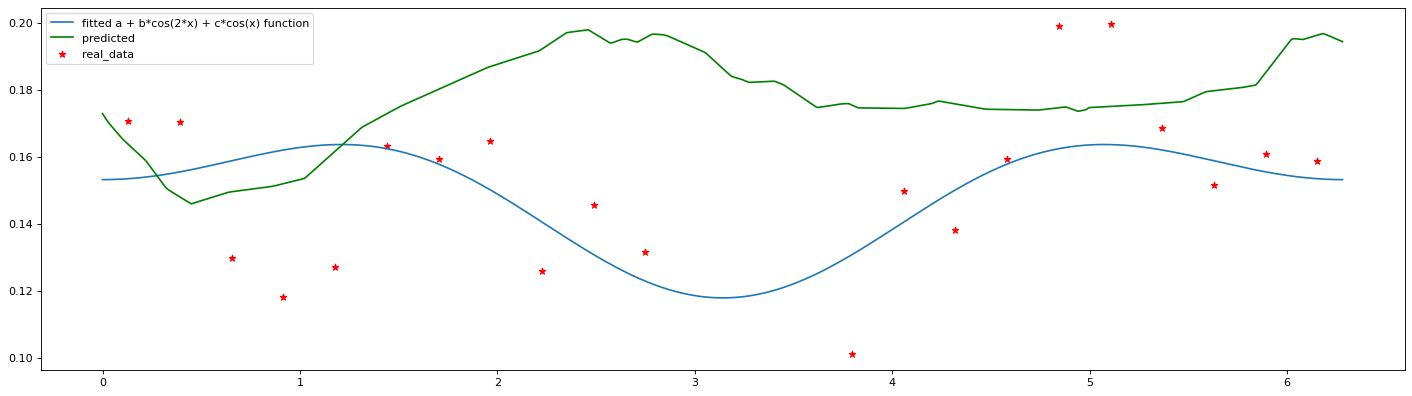

a = 0.683583333330068 , b = 0.09904330095788727, c = -0.21233518469605617


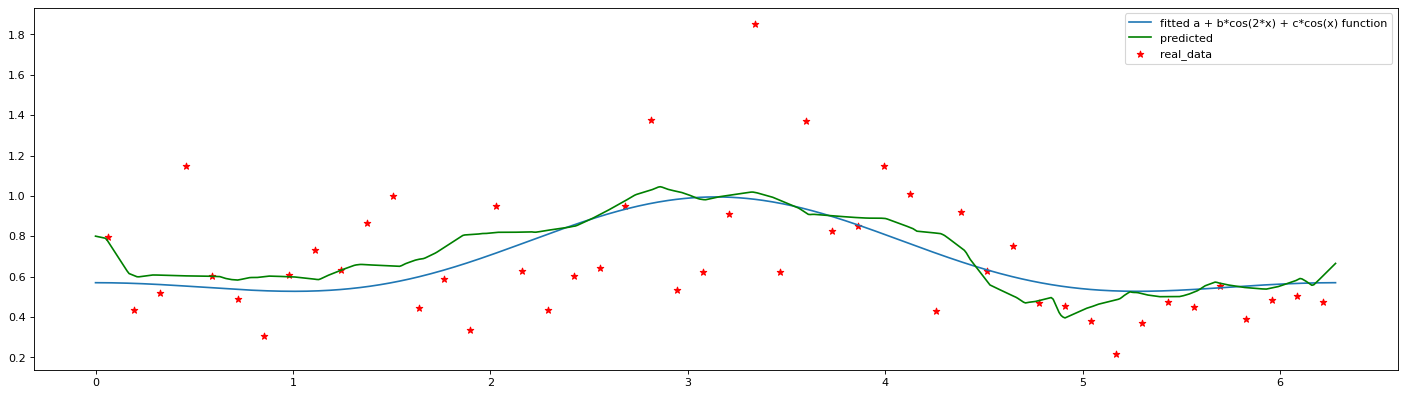

a = 1.2550279166666667 , b = -0.5879560267740573, c = 0.24741467963109948


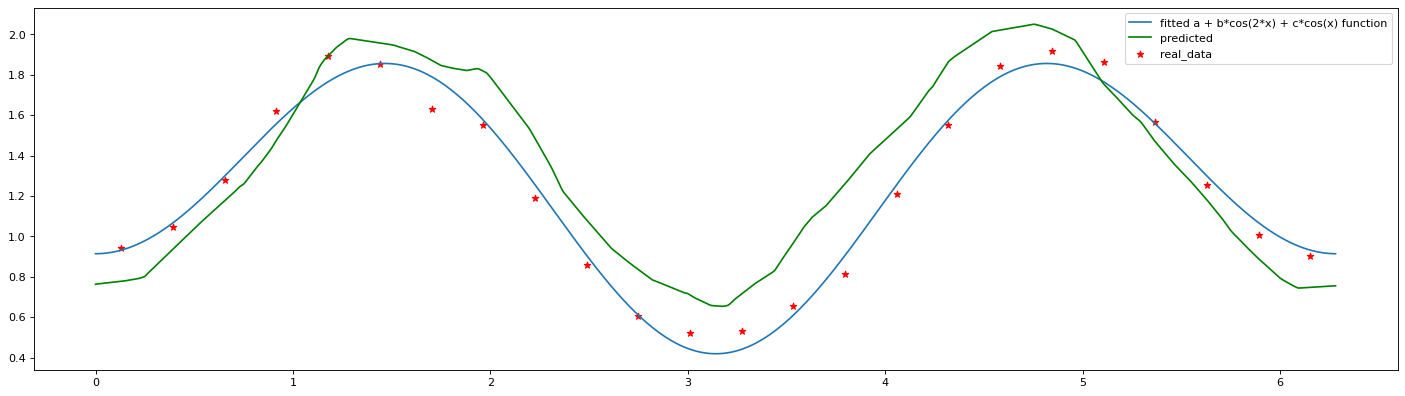

a = 0.34699166656829294 , b = -0.08120431483533917, c = -0.06081283617222721


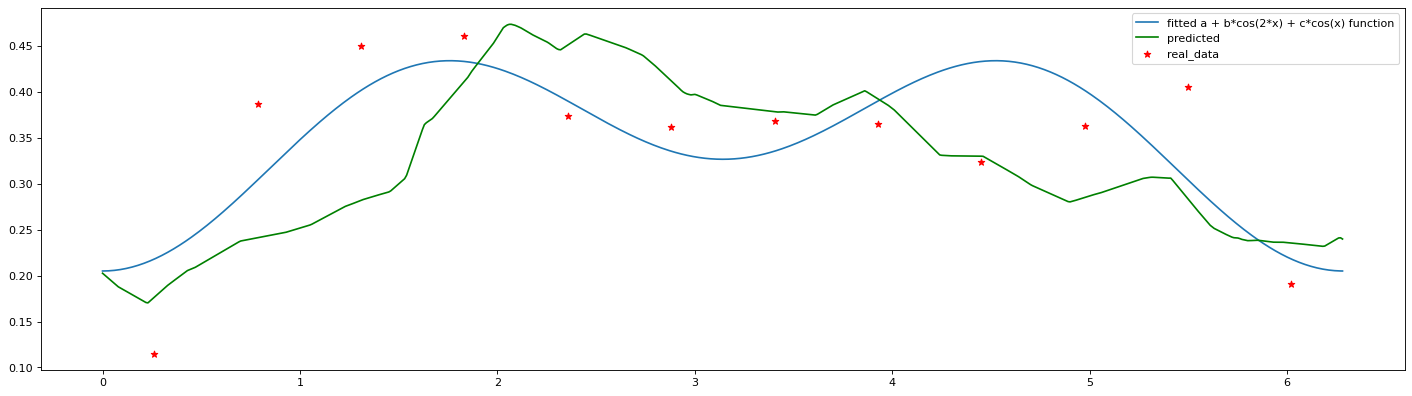

a = 0.8448945856551248 , b = -0.05269399841396405, c = 0.058551423281847814


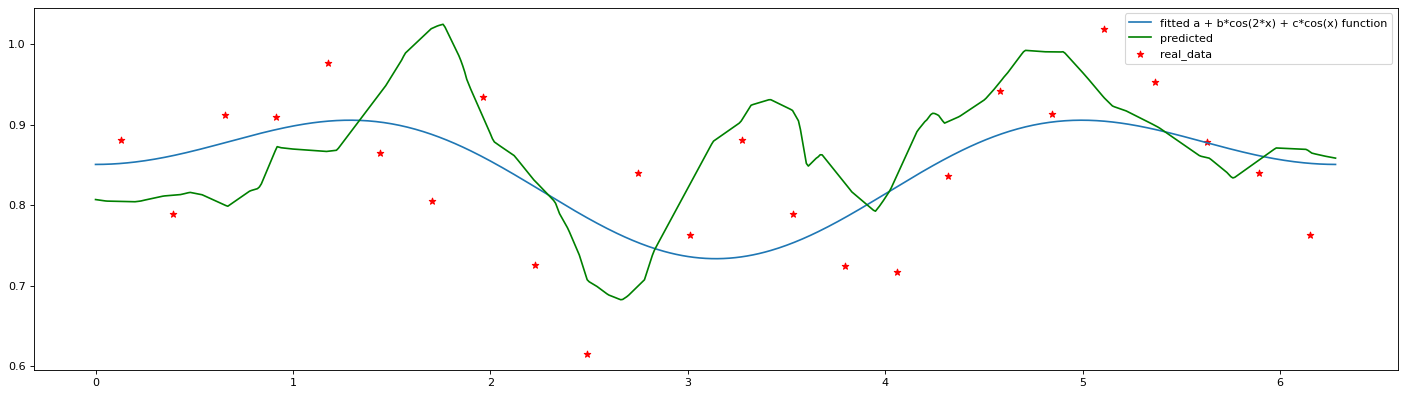

a = 0.16952 , b = -0.025431667503244403, c = 0.02074928704945846


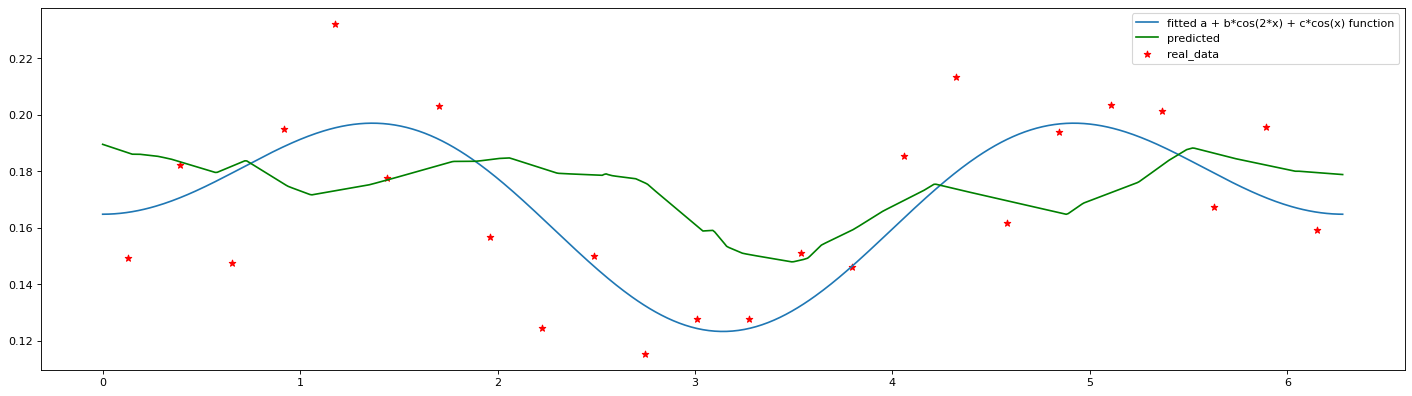

a = 0.17755846185596305 , b = -0.0460253959052124, c = -0.0191605254716718


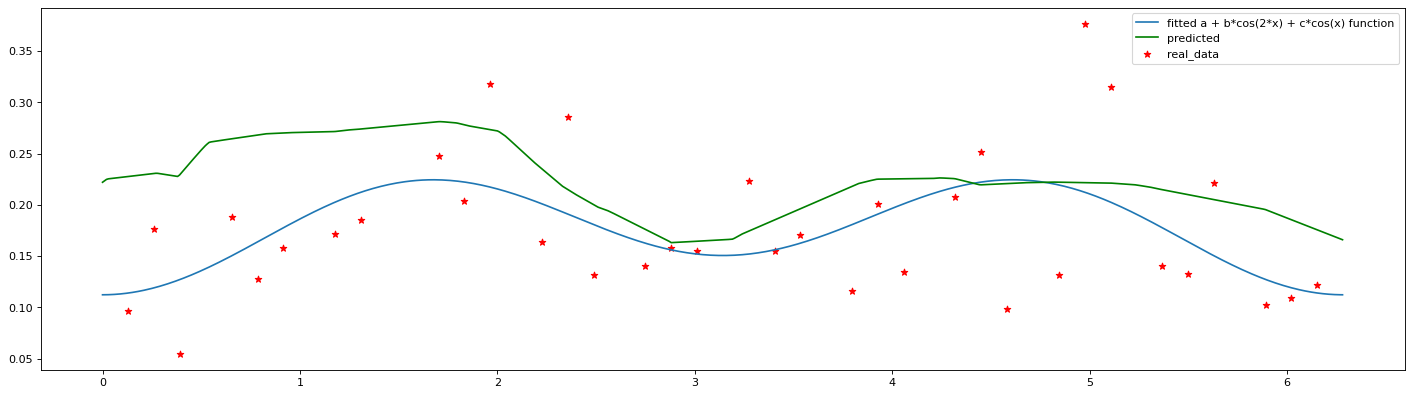

a = 1.1024270541572057 , b = -0.28080980717768284, c = -0.11233789821484241


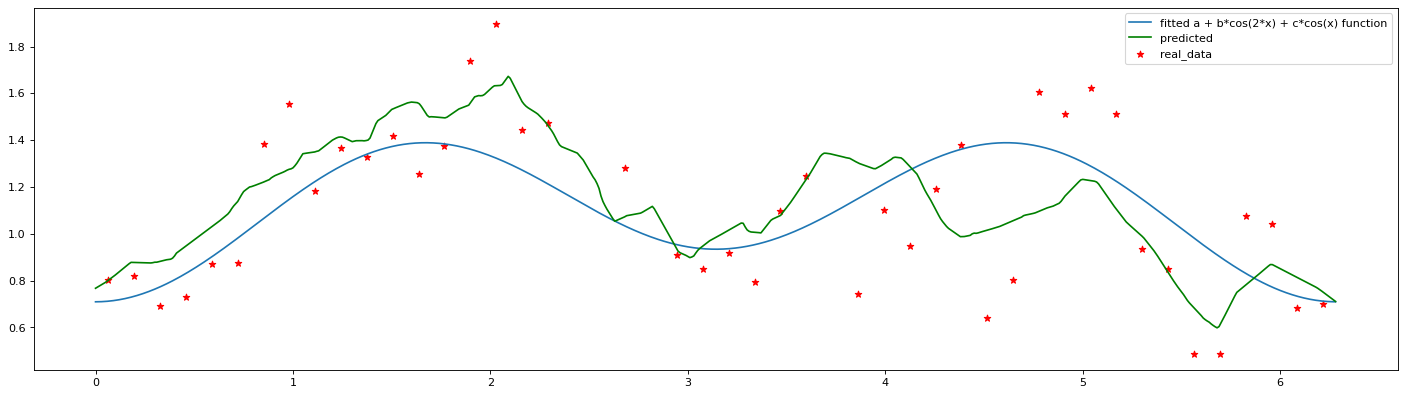

a = 0.5200234056810462 , b = -0.23173120280639536, c = -0.041448441261747265


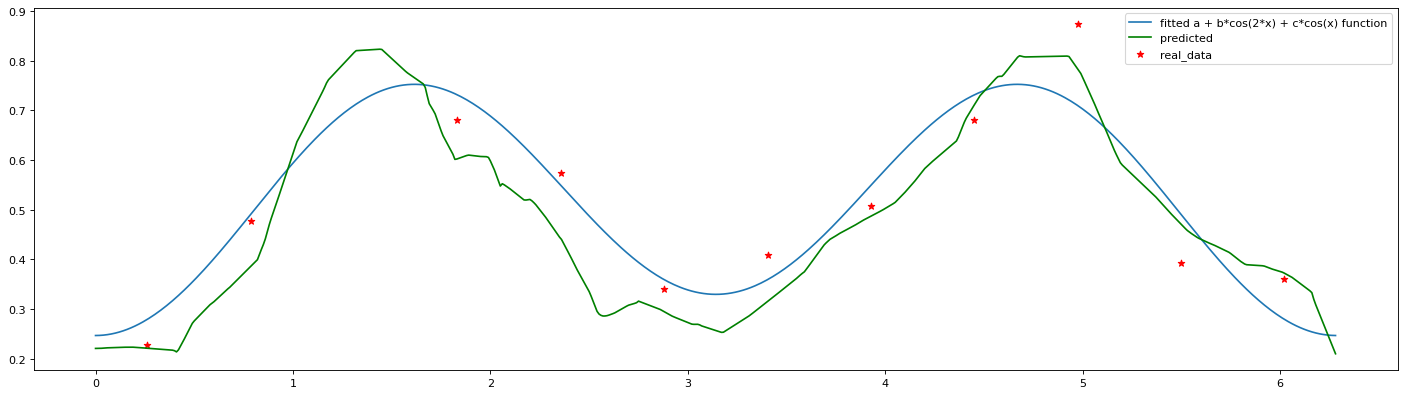

a = 0.5271886961605265 , b = -0.010018147115710141, c = 0.08895018481998196


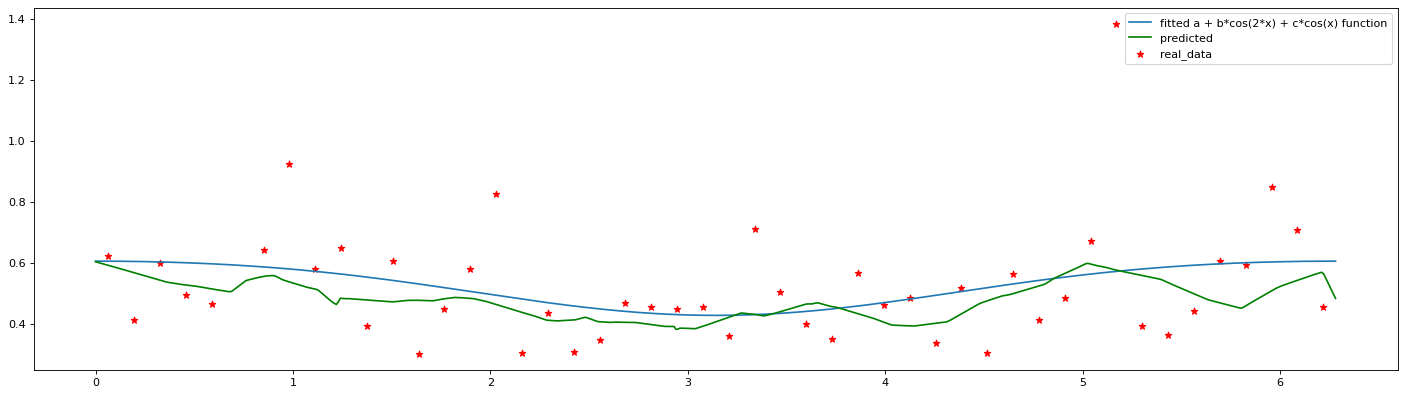

a = 0.38272455956638374 , b = -0.00879680211482503, c = 0.015868622196299476


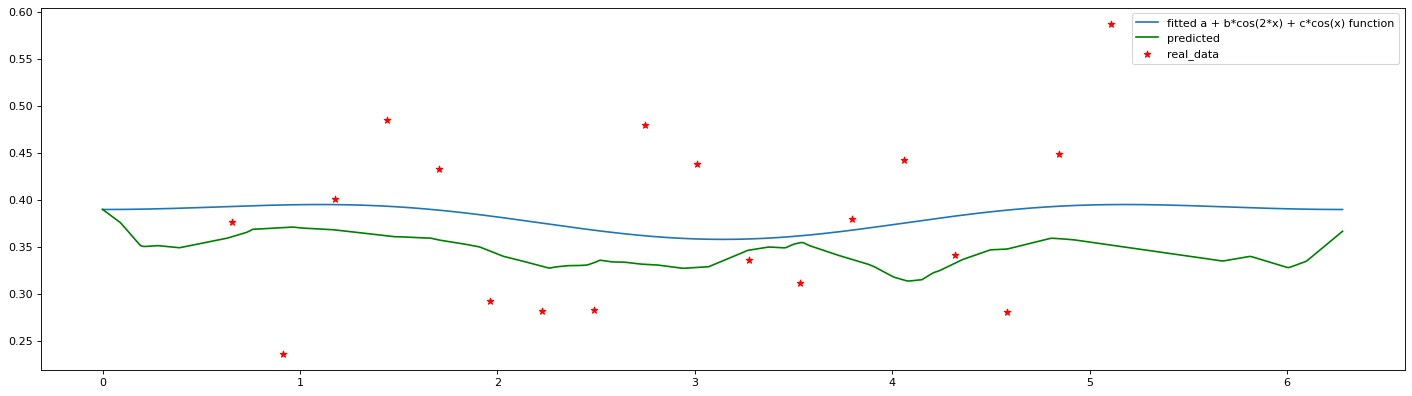

a = 0.09512083333333331 , b = -0.011459808554126429, c = 0.015433404236724341


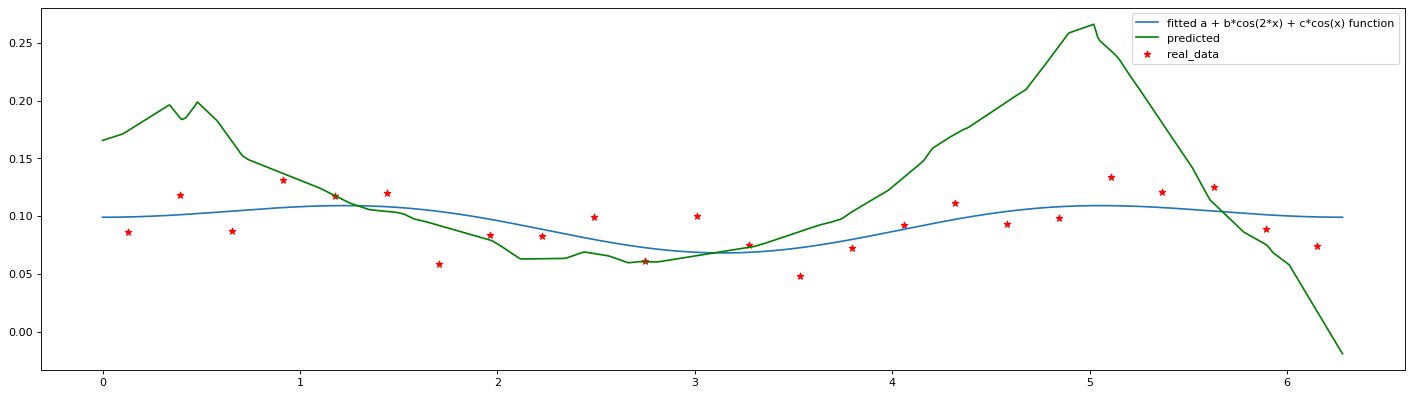

a = 0.11971740723122083 , b = 0.0016345478262856845, c = 0.013157639220031308


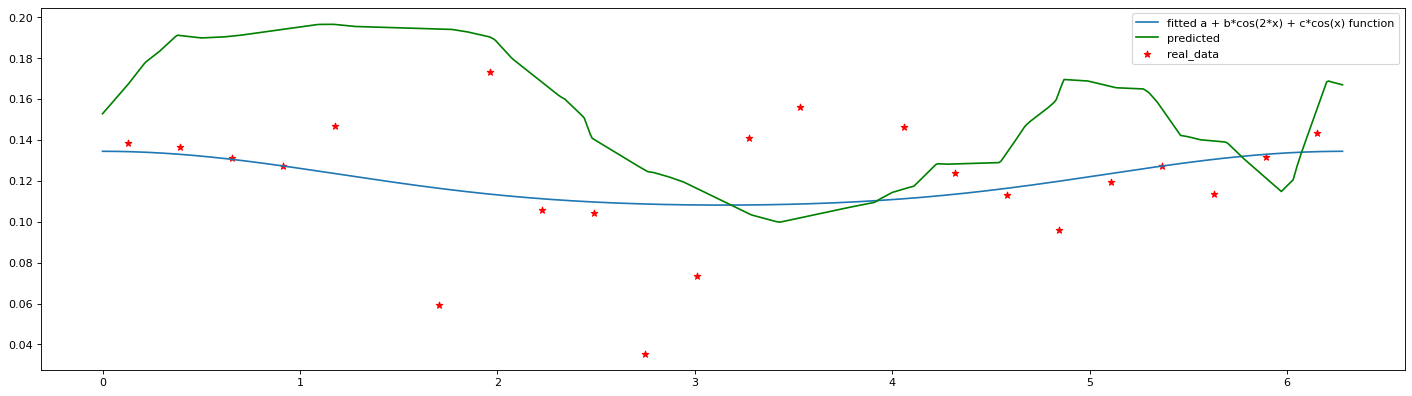

a = 0.3237916666666666 , b = -0.010276832257927271, c = 0.03736733823871936


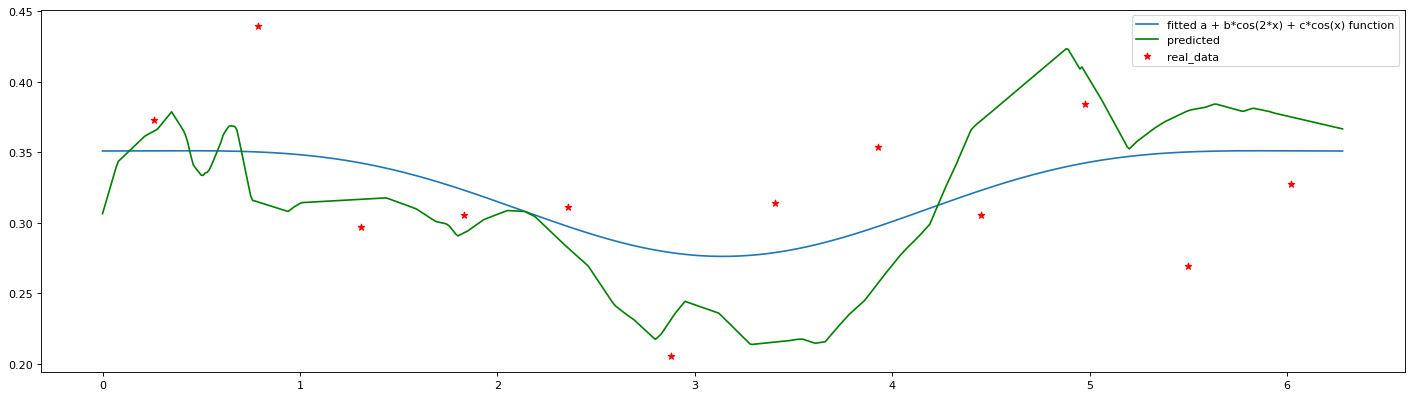

a = 7.658999996622971 , b = 0.755607163098757, c = -1.7312436580323902


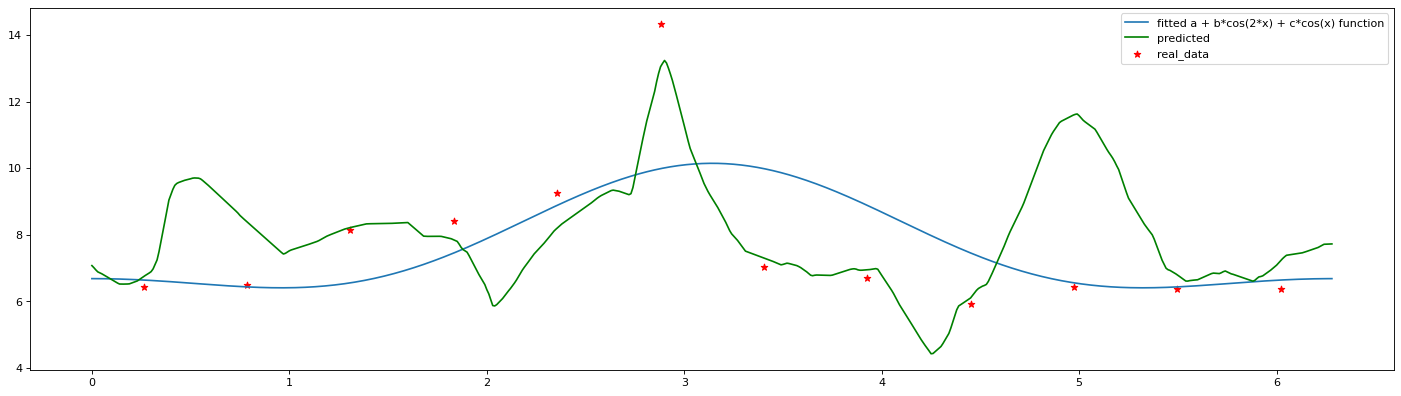

a = 1.0728083077521706 , b = -0.9209595753544739, c = 0.2002410433049597


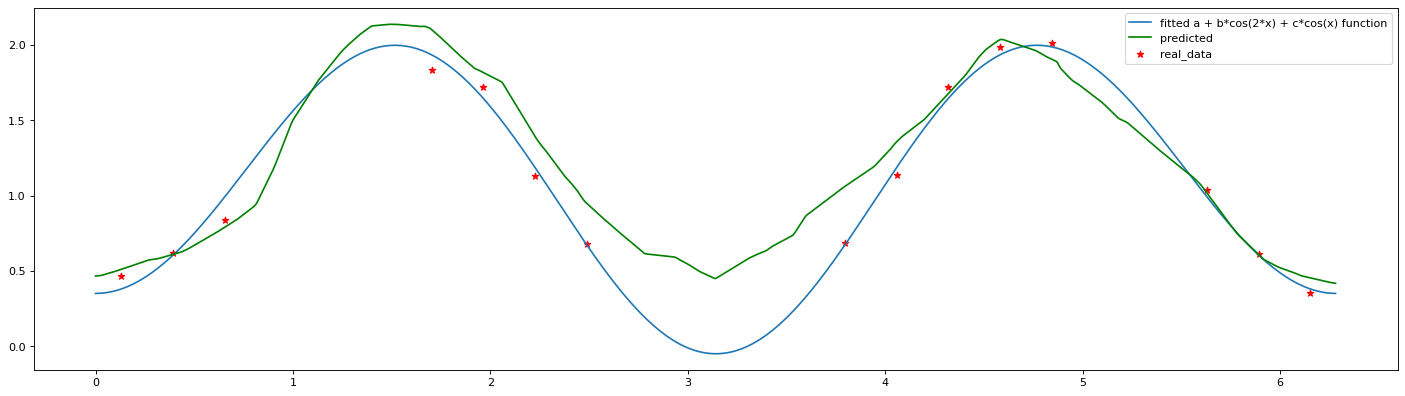

a = 0.4302 , b = -0.10070432148809759, c = -0.07540155362834798


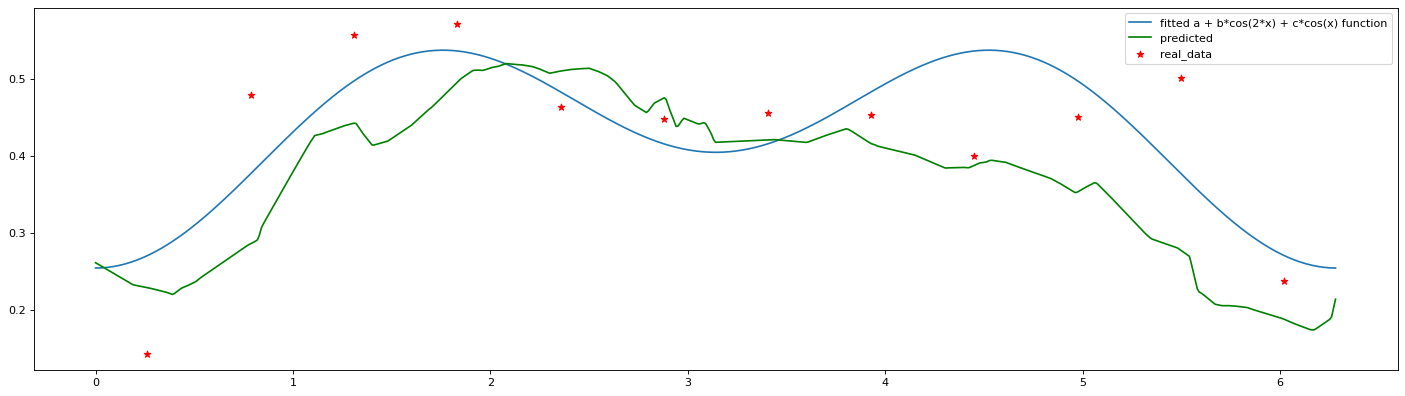

In [171]:
for i in range(1,40):
    rundom_example_check(df, randint(0, len(df)))